In [560]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.utils import column_or_1d
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
import numpy as np

In [561]:
#This sends warning messages to the cornfield

import warnings
def ignore_warnings(*args, **kwargs):
    pass
warnings.warn = ignore_warnings

In [562]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

Join test and train so we can do EDA, I used the keys 'test' and 'train' so that I can split the file easily when I'm done. Making a multi indexed array is a bit problamatic for certain instances but nameing the indexes solves the problem. Added sort = False to avoid a warning. It's good to get practice.

In [563]:
test_train = pd.concat([test,train],keys = ['test','train'],sort = False)

In [564]:
test_train.index.levels[0].name = 'og'
test_train.index.levels[1].name = 'pip'

Replacing spaces with _ and making everthing lowercase

In [565]:
test_train.columns = [i.lower().replace(' ','_') for i in test_train.columns.get_values()]

The value year_remod/add puts the year constructed if no renovations ever took place. That's awful. Let's replace those values with 0 if no renovations took place

In [566]:
test_train['year_remod/add'] = np.where(test_train['year_remod/add'] == test_train.year_built, 0, test_train['year_remod/add'])
        
#I tried to do this with .apply() but it wasn't happy.

In [567]:
#test_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2930 entries, (test, 0) to (train, 2050)
Data columns (total 81 columns):
id                 2930 non-null int64
pid                2930 non-null int64
ms_subclass        2930 non-null int64
ms_zoning          2930 non-null object
lot_frontage       2440 non-null float64
lot_area           2930 non-null int64
street             2930 non-null object
alley              198 non-null object
lot_shape          2930 non-null object
land_contour       2930 non-null object
utilities          2930 non-null object
lot_config         2930 non-null object
land_slope         2930 non-null object
neighborhood       2930 non-null object
condition_1        2930 non-null object
condition_2        2930 non-null object
bldg_type          2930 non-null object
house_style        2930 non-null object
overall_qual       2930 non-null int64
overall_cond       2930 non-null int64
year_built         2930 non-null int64
year_remod/add     2930 non-null int64
roof

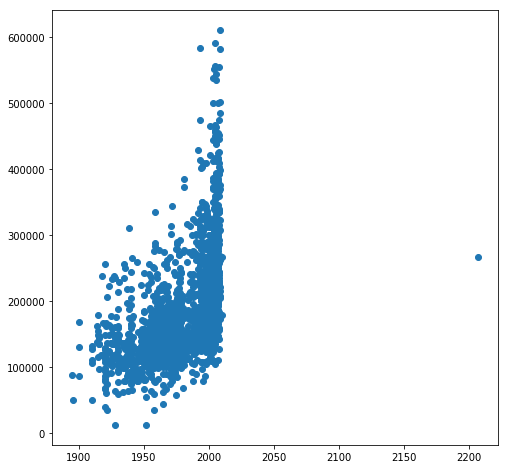

In [574]:
>>> 
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(x=test_train.garage_yr_blt, y=test_train.saleprice)
#fig, ax = plt.subplots(figsize=(8,8));

Making a bunch of dummy variables. This includes some columns that appear to have numbers but these are just dates or codes

In [575]:
test_train = pd.get_dummies(test_train, columns=['ms_zoning','street','alley','lot_shape','land_contour','utilities',
                                                 'lot_config', 'land_slope','neighborhood','condition_1','condition_2',
                                                 'bldg_type','house_style','roof_style','roof_matl','exterior_1st',
                                                 'exterior_2nd','mas_vnr_type','exter_qual','exter_cond', 'foundation',
                                                 'bsmt_qual','bsmt_cond','bsmt_exposure','bsmtfin_type_1',
                                                 'bsmtfin_type_2','heating','heating_qc','central_air',
                                                 'electrical','kitchen_qual','functional','garage_type',
                                                 'garage_finish','garage_qual','garage_cond','paved_drive',
                                                 'fence','misc_feature','sale_type','pool_qc','fireplace_qu', 
                                                 'garage_yr_blt','ms_subclass','year_built','year_remod/add',
                                                 'overall_qual','overall_cond'])

- Dropping garage_yr_blt_2207 because that's obviously a typo
- Dropping year_remod/add_0 because those are garbage values I put in

In [576]:
test_train.drop(['garage_yr_blt_2207.0', 'year_remod/add_0'],axis = 1, inplace=True)

- Filling NaN values with the median or zero values so the data is still usable and it shouldn't affect the results poorly

In [577]:
test_train.lot_frontage.fillna(test_train.lot_frontage.median(), inplace=True)
test_train.mas_vnr_area.fillna(0, inplace=True)
test_train.bsmtfin_sf_1.fillna(0, inplace=True)
test_train.bsmtfin_sf_2.fillna(0, inplace=True)
test_train.bsmt_unf_sf.fillna(0, inplace=True)
test_train.bsmt_full_bath.fillna(0, inplace=True)
test_train.bsmt_half_bath.fillna(0, inplace=True)
test_train.garage_cars.fillna(0, inplace=True)
test_train.garage_area.fillna(0, inplace=True)
test_train.total_bsmt_sf.fillna(0, inplace=True)

- Let's add up the square footage and use it as a column.

In [578]:
#test_train.info(verbose=True)

In [579]:
test_train['total_sf'] = test_train['1st_flr_sf'] + test_train['2nd_flr_sf'] + test_train['bsmtfin_sf_1'] + test_train['bsmtfin_sf_2']

In [580]:
#test_train.info(verbose=True)

- Let's get rid of id and pid since those are only internal identifiers and have no berring on anything.

In [581]:
test_train.drop(['id', 'pid'],axis = 1, inplace=True)

-Time to split up the dataframes

In [582]:
X_test = pd.DataFrame(test_train.loc['test'])
X_test.to_csv('./Data/Test_Clean.csv', index=False)

In [583]:
X_train = pd.DataFrame(test_train.loc['train'])
X_train.to_csv('./Data/Train_Clean.csv', index=False) 

In [584]:
#X_train.head()

-Now lets see the coeff of the columns in our train data

In [585]:
train_cor = X_train.corr()
#train_cor

- Let's get the values with the bigges and smallest corilation 

In [586]:

corr_values_h = train_cor.nlargest(13,'saleprice')
#corr_values_h.T
#corr_values_l = X_train.nsmallest(10,'saleprice')

- Turn them into a list and merge the values we want

In [587]:
#corr_l_lst = corr_values_l.index.get_values()
corr_h_lst = corr_values_h.index.get_values()
features = list(corr_h_lst) 

- Let's make some graphs  so we can see what we are working with.

In [588]:
features

['saleprice',
 'total_sf',
 'gr_liv_area',
 'garage_area',
 'garage_cars',
 'total_bsmt_sf',
 '1st_flr_sf',
 'bsmt_qual_Ex',
 'kitchen_qual_Ex',
 'full_bath',
 'foundation_PConc',
 'totrms_abvgrd',
 'mas_vnr_area']

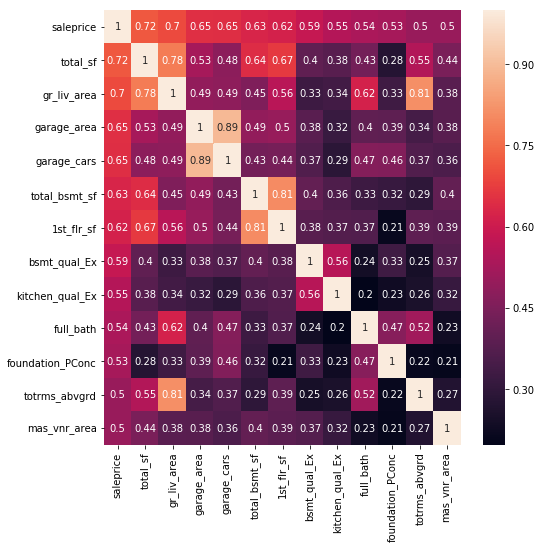

In [591]:
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(X_train[features].corr(),annot=True);

- Let's make a pariplot with these values to see if anything interesting is afoot

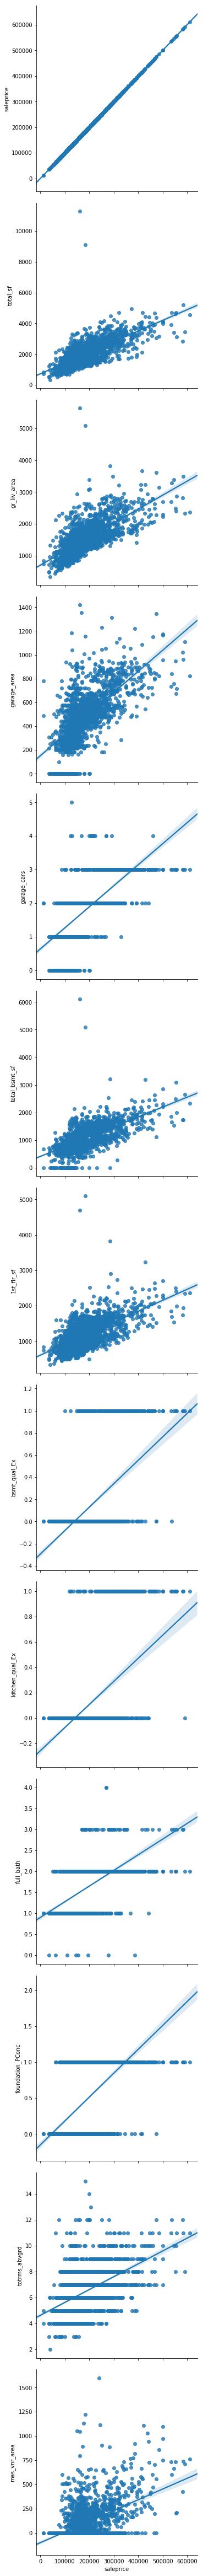

In [527]:
#temp_feat = list(features[1,12])
#fig, ax = plt.subplots(figsize=(10,10)) 
#plt.rcParams['figure.figsize']=(20,20)

sns.pairplot(X_train[features], y_vars= X_train[features].columns.values.tolist(), 
             x_vars='saleprice', kind = "reg", size = 5);
#plt.rcParams['figure.figsize']=(20,20)

- something weird is going on. Looks like two people purchased some houses with very large basements with a;most no first floor for next to nothing. Missile silo? I don't want to know. Let's just dump it since it's messing up our data.

In [528]:
X_train.drop(X_train.index[(X_train.total_sf >8000)], inplace=True) 

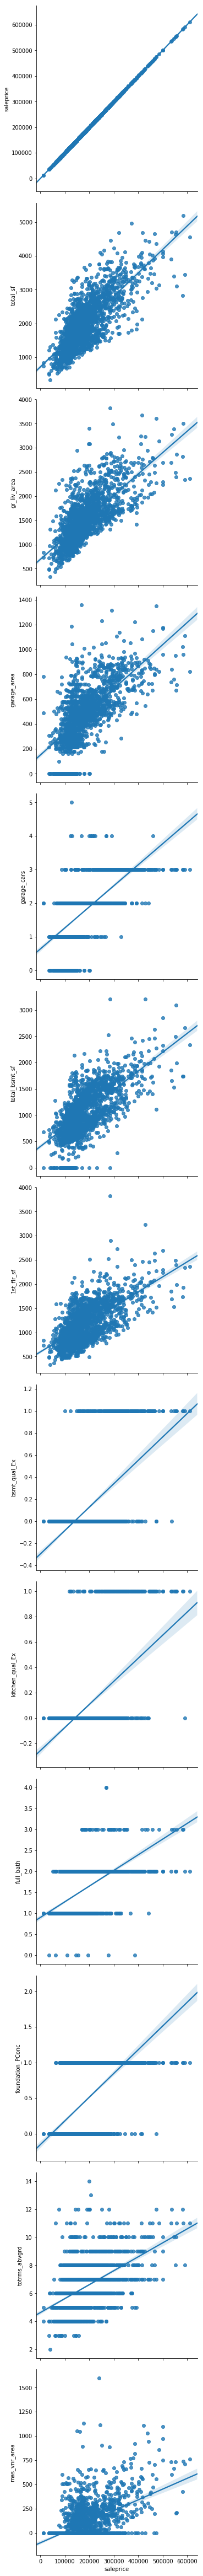

In [529]:
sns.pairplot(X_train[features], y_vars= X_train[features].columns.values.tolist(), 
             x_vars='saleprice', kind = "reg", size = 5);

That's much better. 

In [530]:
corr_values_h = train_cor.nlargest(13,'saleprice')
#corr_values_h.T

corr values did not change.

Time to do some pre processing on the data above. We'll get the top five corr and square and cube them. Unfortunaltely the below did not work.

X_train['2x_total_sf'] = X_train.total_sf ** 2

X_train['3x_total_sf'] = X_train.total_sf ** 3

X_train['2x_gr_liv_area'] = X_train.gr_liv_area ** 2

X_train['3x_gr_liv_area'] = X_train.gr_liv_area ** 3

X_train['2x_garage_area'] = X_train.garage_area **2

X_train['3x_garage_area'] = X_train.garage_area **3

X_train['2x_garage_cars'] = X_train.garage_cars **2

X_train['3x_garage_cars'] = X_train.garage_cars **3

X_train['2x_total_bsmt_sf'] = X_train['total_bsmt_sf'] **2

X_train['3x_total_bsmt_sf'] = X_train['total_bsmt_sf'] **3

X_test['2x_total_sf'] = X_test.total_sf ** 2

X_test['3x_total_sf'] = X_test.total_sf ** 3

X_test['2x_gr_liv_area'] = X_test.gr_liv_area ** 2

X_test['3x_gr_liv_area'] = X_test.gr_liv_area ** 3

X_test['2x_garage_area'] = X_test.garage_area **2

X_test['3x_garage_area'] = X_test.garage_area **3

X_test['2x_garage_cars'] = X_test.garage_cars **2

X_test['3x_garage_cars'] = X_test.garage_cars **3

X_test['2x_total_bsmt_sf'] = X_test['total_bsmt_sf'] **2

X_test['3x_total_bsmt_sf'] = X_test['total_bsmt_sf'] **3

In [531]:
#X_train.head()

Let's goof with y.

In [532]:
y_train = pd.DataFrame(X_train.saleprice)

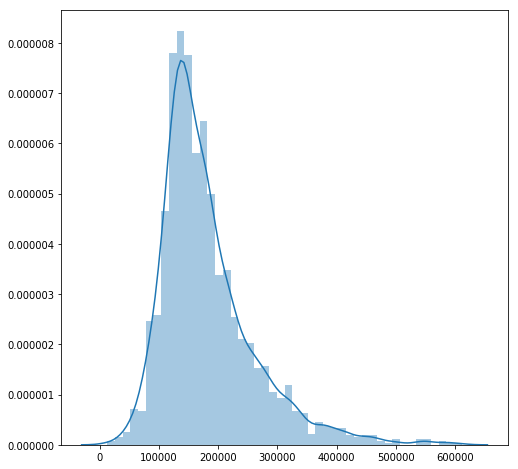

In [533]:
fig, ax = plt.subplots(figsize=(8,8)) 
sns.distplot(y_train)
plt.xlabel='SalePrice';

Thats almost normal. Let's look at y in a probability graph. BTW, this didn't improve accuracy so I removed them.

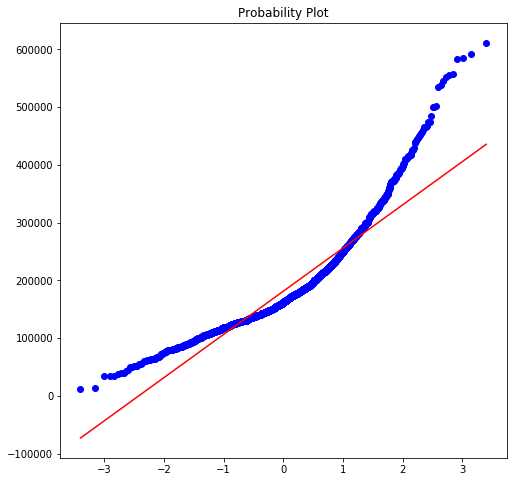

In [534]:
fig, ax = plt.subplots(figsize=(8,8)) 
stats.probplot(y_train.saleprice, plot=plt);

Taking the log to see if we get better results

In [535]:
X_train_temp = pd.DataFrame(np.log(y_train.saleprice))

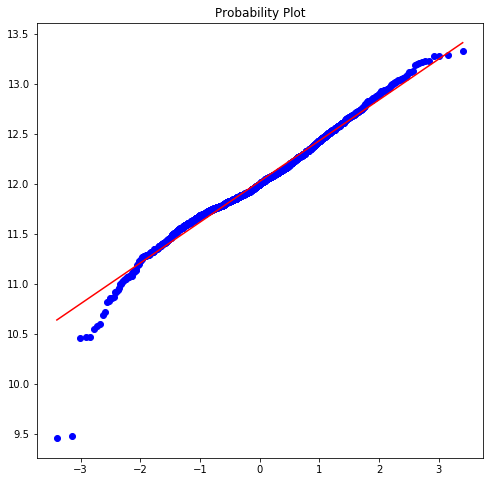

In [536]:
fig, ax = plt.subplots(figsize=(8,8)) 
stats.probplot(X_train_temp.saleprice, plot=plt);

Eh. We should get rid of those two crazy low values.

In [537]:
X_train_temp.drop(X_train.index[X_train_temp.saleprice == X_train_temp.saleprice.min()], inplace=True)

In [538]:
X_train_temp.drop(X_train_temp.index[X_train_temp.saleprice == X_train_temp.saleprice.min()], inplace=True)

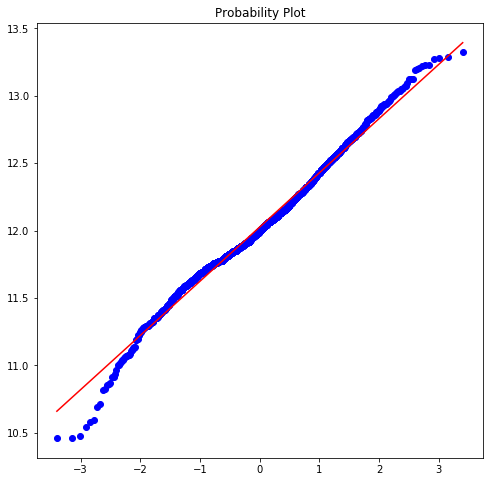

In [539]:
fig, ax = plt.subplots(figsize=(8,8)) 
stats.probplot(X_train_temp.saleprice, plot=plt);

In [540]:
y_train = pd.DataFrame(X_train.saleprice)
X_train.drop(['saleprice'], axis=1, inplace=True)

In [541]:
#X_train.head()

Now let's drop the rogue saleprice column in test. It was filled with garbage anyway.

In [542]:
X_test.drop(['saleprice'],axis=1, inplace=True)

Let's save everthing to csv so we don't have to do this again.

In [543]:
X_train.to_csv('./Data/X_train_clean.csv',index=False)
y_train.to_csv('./Data/y_train_clean.csv',index=False)
X_test.to_csv('./Data/X_test_clean.csv',index=False)

Ok. Time to import the data modeling

In [544]:
from sklearn.utils import column_or_1d
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from scipy import stats
from keras.models import Sequential
from keras.layers import Dense

First let's scale the data.

In [545]:
#X_train.head()

In [546]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

Some models throw errors withou this

In [547]:
y_train_array = column_or_1d(y_train)

Setting up KFold

In [548]:
kf = KFold(n_splits=10, shuffle=True)

Now for the models. I'm going to start with Lasso and work fom there. I started with an alpha range of np.logspace(-4,-.5,30) and worker from there.

In [549]:
l_alphas = np.logspace(2.7, 3,5, 100)
lasso_model = LassoCV(alphas=l_alphas, cv=kf)
lasso_model = lasso_model.fit(X_train_sc, y_train_array)

In [550]:
optimus_alpha = lasso_model.alpha_
optimus_alpha

501.18723362727246

In [551]:
lasso_model.score(X_train_sc,y_train_array)

0.9428432301217395

In [552]:
cleo = lasso_model.predict(X_test_sc)

df_cleo = pd.DataFrame({'Id': test.Id,'SalePrice':cleo})

df_cleo.to_csv('./Data/True_Final_Lasso_sc.csv',index=False)

df_test = pd.read_csv('./Data/True_Final_Lasso_sc.csv')
df_test.head()

,Id,SalePrice
0,2658,128401.235791
1,2718,158315.899972
2,2414,216220.167578
3,1989,109909.212953
4,625,180338.328114


This scored 36661.36783 in kaggle. Lets see Ridge. I started with the alpha range above. 

In [130]:
r_alphas = np.logspace(2.65, 2.75, 100)
ridge_model = RidgeCV(alphas=r_alphas, cv=kf)
ridge_model = ridge_model.fit(X_train_sc, y_train_array)

In [131]:
optimus_alpha_r = ridge_model.alpha_
optimus_alpha_r

499.4417555536736

In [139]:
ridge_model.score(X_train_sc,y_train_array)

0.94853161144614

In [133]:
cleo = ridge_model.predict(X_test_sc)

df_cleo = pd.DataFrame({'Id': test.Id,'SalePrice':cleo})

df_cleo.to_csv('./Data/True_Final_Ridge_Sc.csv',index=False)

df_test = pd.read_csv('./Data/True_Final_Ridge_Sc.csv')
df_test.head()

,Id,SalePrice
0,2658,130907.140817
1,2718,158863.905736
2,2414,220761.858636
3,1989,104464.115850
4,625,179403.313969


This scored 36605.43933. Let's see Elastic net.

In [136]:
enet_alphas = np.logspace(-1, 0.03, 100)
enet_ratio = 0.5
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=kf)
enet_model = enet_model.fit(X_train_sc, y_train_array)

In [137]:
optimus_alpha_e = enet_model.alpha_
optimus_alpha_e

0.5222504079284582

In [140]:
enet_model.score(X_train_sc, y_train_array)

0.9480712361310409

In [141]:
cleo = enet_model.predict(X_test_sc)

df_cleo = pd.DataFrame({'Id': test.Id,'SalePrice':cleo})
df_cleo.to_csv('./Data/True_Final_ENet_sc_5.csv',index=False)

df_test = pd.read_csv('./Data/True_Final_ENet_sc_5.csv')
df_test.head()

,Id,SalePrice
0,2658,129750.173948
1,2718,159076.418537
2,2414,220921.508953
3,1989,104722.899230
4,625,179592.408132


This scorred 36630.94268. Changing the ENet ratio probably will not help since they are so close. Let's move on to more exotic means.

In [143]:
X_train_c = sm.add_constant(X_train)
X_test_c = sm.add_constant(X_test)

results = sm.GLM(y_train,
                 X_train_c,
                 family = sm.families.Gamma())
gamma_results =results.fit()
#results.summary()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              saleprice   No. Observations:                 2049
Model:                            GLM   Df Residuals:                     1516
Model Family:                   Gamma   Df Model:                          532
Link Function:          inverse_power   Scale:                        0.010724
Method:                          IRLS   Log-Likelihood:                -22685.
Date:                Wed, 22 Aug 2018   Deviance:                       17.350
Time:                        23:06:20   Pearson chi2:                     16.3
No. Iterations:                    12   Covariance Type:             nonrobust
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.807e-06   3.55e-06     -0.510      0.610   -8.76e-06    5.14e-06
lot_frontage          

/home/steven/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/steven/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/steven/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/steven/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [146]:
cleo = gamma_results.predict(X_test_c)
df_cleo = pd.DataFrame({'Id': test.Id,'SalePrice':cleo})

df_cleo.to_csv('./Data/Final_Gamma5.csv',index=False)

df_test = pd.read_csv('./Data/Final_Gamma5.csv')
df_test.head()

,Id,SalePrice
0,2658,82348.058267
1,2718,145768.300104
2,2414,215769.260250
3,1989,110143.099317
4,625,172508.284311


That first data point looks really wrong. Didn't send this up

In [155]:
knn = KNeighborsClassifier(n_neighbors=1, p = 4, metric='manhattan')
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=1, p=4,
           weights='uniform')

In [156]:
knn.score(X_train_sc,y_train)

0.9995119570522206

In [158]:
cleo = knn.predict(X_test_sc)

df_cleo = pd.DataFrame({'Id': test.Id,'SalePrice':cleo})

df_cleo.to_csv('./Data/True_Final_KNN1_Sc.csv',index=False)

df_test = pd.read_csv('./Data/True_Final_KNN1_Sc.csv')
df_test.head()

,Id,SalePrice
0,2658,118000.0
1,2718,119000.0
2,2414,171925.0
3,1989,120000.0
4,625,154000.0


This had a score of 56145.27377 That's terrible compared to Lasso and Ridge

I tried to do some more complex models but I never really got anywhere with them. Hope you enjoyed.